# Week 5 - Regression models

**IMPORTANT NOTICE**: In this notebook, we will use Python's Pandas package. Besides installing it (you may already have it), note that it is a very powerful tool for data cleaning and data preparation. You will see some examples of this. If you never worked with it, we recommend you to take an hour or so to take a look at the concept of Dataframe, and main methods used. There are various nice Pandas tutorials online like, for example, the following quick tutorial: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

## Part 2.1 -  Modelling taxi pickups in Wall Street (NYC)

In this notebook, we will consider the problem of modelling taxi pickups in Wall Street (see area in the map below).

<img src="http://mlsm.man.dtu.dk/mbml/wall_street.png">

But before we go into details, the usual imports...

In [3]:
# Install Pyro, if necessary
# !pip install pyro-ppl

In [4]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools
from scipy import stats

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Lets start by loading the dataset. In order to let you focus on the probabilistic modelling aspects, we already prepared the raw GPS taxi data for you and extended it with additional information about the weather conditions.

In [5]:
# load csv (original dataset is by 30min intervals, we want 1h intervals) into a Pandas Dataframe
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/pickups+weather_wallstreet.csv")

# look at the first few lines of the loaded dataset
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


Before we do anything with the data, it is always a good idea to try to visualize it.

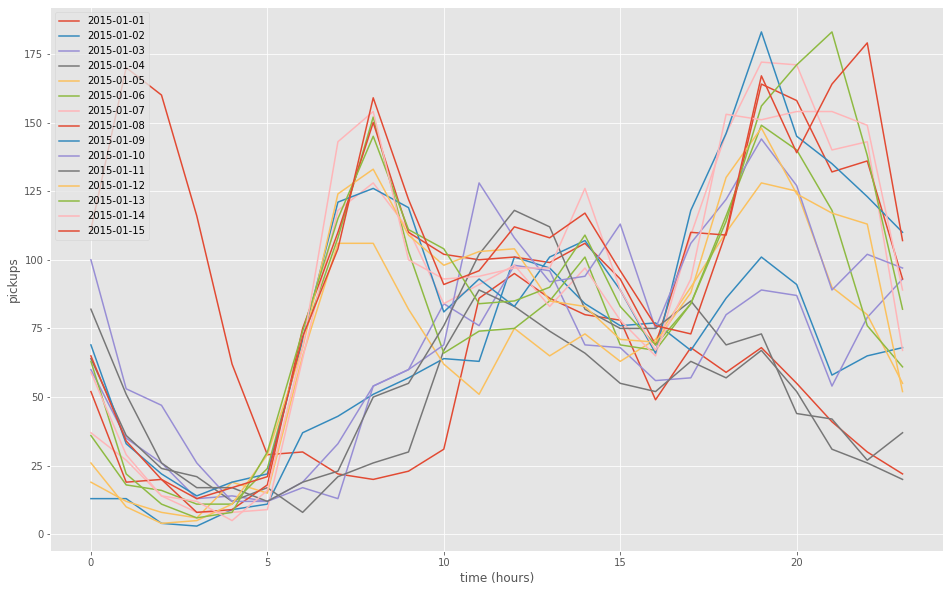

In [6]:
# visualize first 15 days of January 2015
dates = []
for day in range(1,16):   # we will search for days 1-15
    date = "2015-01-%.2d" % (day,)
    dates.append(date)
    plt.plot(df[df.date == date]["pickups"].values)   # select lines with corresponding date
plt.xlabel("time (hours)")
plt.ylabel("pickups")
plt.legend(dates);

We will now preprocess the dataset. Particularly, we will filter the data to keep only data from 2015, and we will also extract some relevant features from the dates (e.g. day of the week and hour of the day).

In [7]:
# convert datetime column to datetime object
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d")

# filter: use only data from 2015
df = df[df.datetime.dt.year == 2015]

# add column with day of week (dow) and time of day (tod)
df["dow"] = df["datetime"].dt.weekday
df["tod"] = df["datetime"].dt.hour

df.head()  #let's see how the dataframe looks like now (notice new columns!)

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder,dow,tod
52584,2015-01-01 00:00:00,111,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,0
52585,2015-01-01 01:00:00,170,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,1
52586,2015-01-01 02:00:00,160,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,2
52587,2015-01-01 03:00:00,116,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,3
52588,2015-01-01 04:00:00,62,2015-01-01,27.0,39.0,5.3,25.1,10.0,1014.6,0.0,0.0,0,0,0,0,3,4


We wish to model the number of taxi pickups in the Wall Street area as a function of features such as the day of the week, time of the day and weather condtitions. 




However, the number of pickups is clearly not a linear function of these variables directly! For example, for time of the day - a discrete variable ranging from 0 to 23 - there's no reason to believe pickups to be proportional to the hour number! 

In order to allow for non-linear relationships, we shall consider a 1-of-K encoding of the day of week and time of day variables.

The Pandas method "get_dummies" exists just for that!

In [8]:
# a short demo of the one_of_K_enc function
enc=np.array(pd.get_dummies(df["tod"]))
print(enc.shape)
print(enc[:50,:]) # first 50 rows of tod. Notice that ech row has 24 numbers (1 one and 23 zeros) 

(8760, 24)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


So, let's do it for the two variables:

In [9]:
# prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
print(X_time.shape)

(8760, 31)


In [10]:
# prepare matrix with weather features
X_weather = df[["min_temp","max_temp","wind_speed","wind_gust",
                "visibility","pressure","precipitation","snow_depth",
                "fog","rain_drizzle","snow_ice"]].values
X_weather = df[["min_temp","snow_depth","precipitation"]].values
print(X_weather.shape)

(8760, 3)


In [11]:
# create matrix with time and weather features
X = np.concatenate([X_time, X_weather], axis=1)
print(X.shape)

# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

(8760, 34)


In [12]:
# prepare vector of target taxi pickups
y = df["pickups"].values

# standardize pickups
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)

(8760,)


We now have all our data prepared and standardized. Note that it is often very important to have your data properly standardized (can you think of potential problems if your data is not standardized?).

The X matrix now contain all the input data for the model, and the y vector contains all the corresponding targets (number of taxi pickups).

The next step is to split our data into a train and test set. Alternatively, we could have used something like cross-validation, but for the sake of simplicity, a train/test split will do just fine for this example.

In [13]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_time_train = X_time[ix_train,:]
X_time_test = X_time[ix_test,:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 5781
num test: 2979


A crucial step in developing a experimental setup in machine learning is establishing how to access the quality of the models that we learn. For this purpose, we developed a funciton which already constains a series of popular metrics for evaluating the quality of the predictions of a regression model (continuous output variables!).

In [14]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

Just for the sake of comparision (and for fun!), lets run linear regression (or Ridge regression) from the popular sklearn package.

In [15]:
#regr = linear_model.LinearRegression()
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.803
MAE: 19.323
RMSE: 25.906
R2: 0.644


### Pyro: Train on a small subset of the data

Time to implement Bayesian linear regression in Pyro! (go back to the lecture slides, if necessary)

Note: since the input matrix X does not include a column with all 1's, we need to model the intercept term explicitly! We therefore shall include a alpha variable (the intercept) in the model for this purpose. The likelihood of the model is then as follows:

$y_n \sim \mathcal{N}(\alpha + \boldsymbol\beta^T \textbf{x}_n , \sigma^2)$

Can you implement the full model in Pyro?

In [16]:
X.shape

(8760, 34)

In [44]:
def model(X, obs=None):
    alpha = pyro.sample('alpha', pyro.distributions.Normal(0., 1.))
    beta = pyro.sample('beta', pyro.distributions.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1])))
    sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(5.))

    with pyro.plate('data'):
        pyro.sample('y', pyro.distributions.Normal(alpha + beta.T@X.T, sigma**2).to_event(), obs=obs)

We begin by doing inference on the model using MCMC (NUTS) and using only a small subsample of the dataset.

In [45]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train[:100,:]).float()
y_train_small = torch.tensor(y_train[:100]).float()

Please run the above model, with the corresponding data

In [46]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [00:46, 25.64it/s, step size=1.40e-01, acc. prob=0.889]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.04      0.23     -0.04     -0.41      0.32    370.40      1.00
   beta[0]     -0.11      0.39     -0.08     -0.78      0.49    145.39      1.00
   beta[1]      0.02      0.39      0.05     -0.67      0.60    140.88      1.01
   beta[2]      0.04      0.40      0.05     -0.61      0.68    143.25      1.01
   beta[3]      0.18      0.39      0.21     -0.45      0.79    139.12      1.01
   beta[4]     -0.04      0.40     -0.02     -0.64      0.64    139.20      1.00
   beta[5]     -0.06      0.39     -0.05     -0.77      0.53    143.63      1.00
   beta[6]     -0.28      0.39     -0.26     -0.90      0.40    140.63      1.00
   beta[7]     -0.12      0.20     -0.12     -0.46      0.17    140.54      1.02
   beta[8]     -0.12      0.21     -0.12     -0.44      0.21    150.83      1.02
   beta[9]     -0.27      0.20     -0.27     -0.59      0.06    137.87      1.02
  beta[10]     -0.24      0

Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

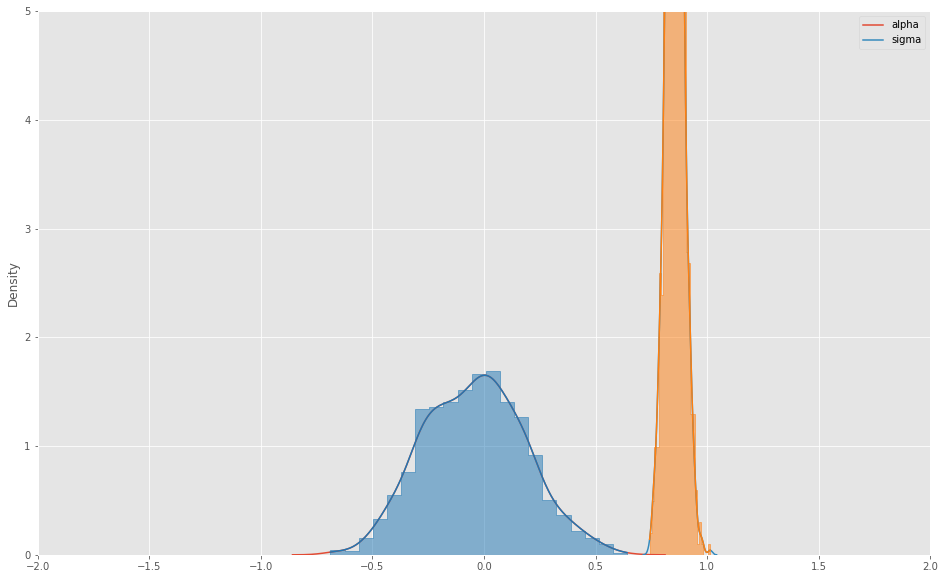

In [47]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.kdeplot(posterior_samples["alpha"])
sns.kdeplot(posterior_samples["sigma"])

# Alternate plotting due to deprecated distplot-function
sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,5])
plt.show()

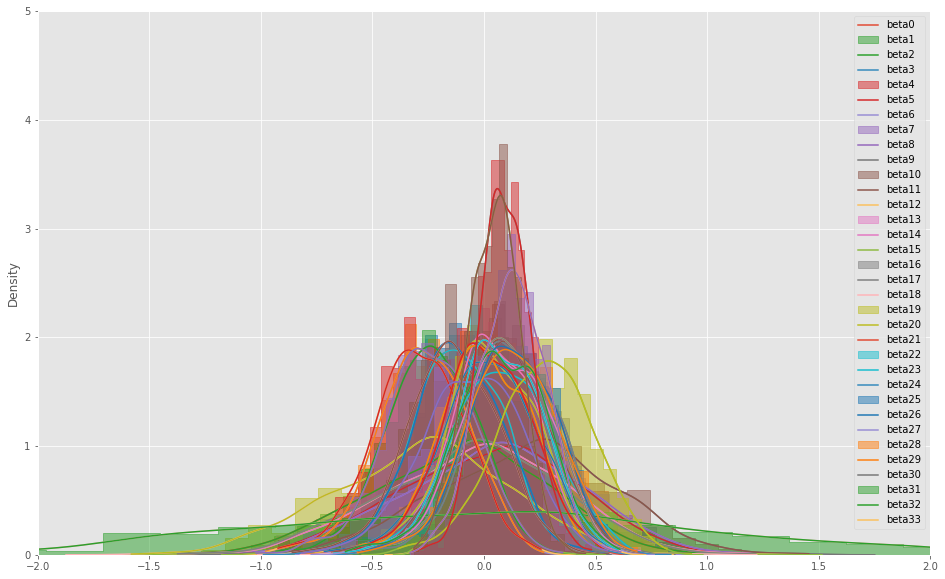

In [48]:
for i in range(X.shape[1]):
    sns.kdeplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    sns.histplot(posterior_samples["beta"][:,i], kde=True, color=next(palette), stat='density', element='step')

plt.legend(["beta%d" % i for i in range(X.shape[1])])
plt.axis([-2,2,0,5])
plt.show()

Given the posterior distributions over the variables alpha and beta, we can make predictions for the test set. In this case there are multiple ways to do this! Lets see...

First, recall that the output of Pyro consists of samples from the posterior distribution of the latent variables (in this case, ```alpha```, ```beta``` and ```sigma```). We can use these samples to compute the mean (or mode!) of the posterior distribution over alpha and beta ($\hat{\alpha}$ and $\hat{\boldsymbol\beta}$, respectively), and then use that mean/mode to make predictions $\hat{y}$ as follows:

$\hat{y}_n = \hat{\alpha} + \hat{\boldsymbol\beta}^T \textbf{x}_n$

Can you create a vector called "y_hat" with the predictions for the test set?

In [49]:
y_hat = stats.mode(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)[0].flatten()
y_hat

array([-0.9006708 , -3.47974901, -2.89924442, ..., -0.25357342,
       -0.43804693, -0.78329998])

Since we standardized the target variable $y$ (number of taxi pickups) before feeding it to the Pyro model, we need to convert the predictions back to original scale before evaluating their quality:

In [50]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.165
MAE: 93.512
RMSE: 143.308
R2: 0.000


What we just did for making predictions seems a bit wasteful. Pyro just computed for us the (whole!) posterior distribution for alpha and beta, and we completely ignored it by looking at its mean (or mode) and using that to make predictions. Furthermore, why use the mean instead of the mode (or vice-versa)? For sure there must be a better way...

Indeed, the proper Bayesian way of making predictions for our Bayesian linear regression model is to follow the rules of probability. Namely, our goal in prediction is to use the posterior over $\alpha$ and $\boldsymbol\beta$ given the observed data, $p(\alpha | \textbf{y}, \textbf{X})$ and $p(\boldsymbol\beta | \textbf{y}, \textbf{X})$ respectively, to compute the posterior distribution of the target variable $y_*$ for a new input vector $\textbf{x}_*$ as follows:

$p(y_* | \textbf{x}_*, \textbf{y}, \textbf{X}, \sigma) = \int \int \mathcal{N}(y_* | \alpha + \boldsymbol\beta^T \textbf{x}_*, \sigma^2) \, p(\alpha | \textbf{y}, \textbf{X}) \, p(\boldsymbol\beta | \textbf{y}, \textbf{X}) \, d\alpha \, d\boldsymbol\beta$

Notice that we are integrating (or marginalizing) over all values of $\alpha$ and $\boldsymbol\beta$. We can think of this as averaging over the values of $\alpha$ and $\boldsymbol\beta$ according to their posterior distributions.

Since Pyro outputs a set of $S$ samples from the posteriors, $\{\alpha^{(s)}, \boldsymbol\beta^{(s)}\}_{s=1}^S$, we can easily use them to approximate the expected value of $y_*$ as follows:

$\mathbb{E}[y_*] \approx \frac{1}{S} \sum_{s=1}^S \alpha^{(s)} + (\boldsymbol\beta^{(s)})^T \textbf{x}_*$

So lets do that!

In [51]:
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

We can evaluate the (new) predictions:

In [52]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.707
MAE: 24.276
RMSE: 31.223
R2: 0.483


Did you get similar error values as before? Probably they didn't change much in this case, because the posteriors of $\alpha$ and $\boldsymbol\beta$ look very Gaussian and also because our likelihood is Gaussian too! But if the posteriors were skewed or multimodal, then this approximation to the Bayesian integral would likely yield quite different results from the ones obtained by using the mean or the mode of the posterior distribution. Therefore, this is something important to be aware of!

### Pyro: Train on a slightly larger subset of the data

We will now do inference on a slightly larget subset of the data, and see what happens...

In [53]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train[:1000,:]).float()
y_train_small = torch.tensor(y_train[:1000]).float()

In [54]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [01:11, 16.69it/s, step size=4.29e-02, acc. prob=0.860]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.04      0.02     -0.04     -0.07     -0.00    230.55      1.00
   beta[0]      0.00      0.35      0.03     -0.55      0.52     68.54      1.03
   beta[1]      0.08      0.35      0.10     -0.47      0.60     68.53      1.03
   beta[2]      0.13      0.35      0.15     -0.47      0.60     68.37      1.03
   beta[3]      0.11      0.35      0.14     -0.47      0.61     68.48      1.03
   beta[4]      0.12      0.35      0.14     -0.45      0.62     68.44      1.03
   beta[5]      0.08      0.35      0.11     -0.48      0.60     68.41      1.03
   beta[6]     -0.17      0.35     -0.14     -0.76      0.32     68.34      1.03
   beta[7]     -0.10      0.21     -0.07     -0.44      0.23     48.68      1.02
   beta[8]     -0.21      0.21     -0.18     -0.55      0.13     48.88      1.02
   beta[9]     -0.31      0.21     -0.28     -0.64      0.04     48.20      1.02
  beta[10]     -0.34      0

Plot the posterior distribution of all the latent variables in the model (alpha, betas and sigma).

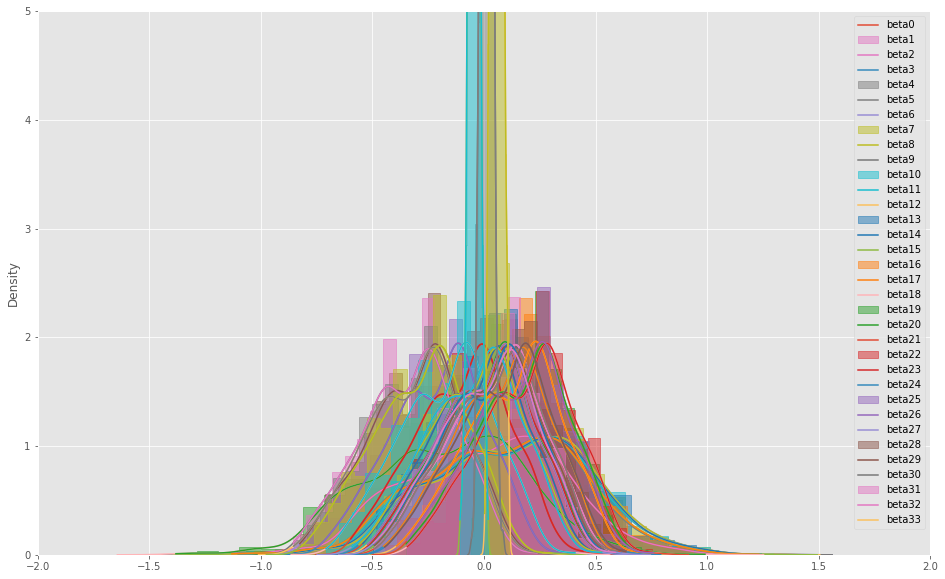

In [55]:
posterior_samples = mcmc.get_samples()
for i in range(X_train_small.shape[1]):
    sns.kdeplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    sns.histplot(posterior_samples["beta"][:,i], kde=True, color=next(palette), stat='density', element='step')

plt.legend(["beta%d" % i for i in range(X.shape[1])])
plt.axis([-2,2,0,5])
plt.show()

Compare the new posterior distributions with the ones obtained by using only 100 data points from the dataset (above). Be careful with the scales of the plots...

Notice how the model is now much more confident about the posterior distribution of the latent variables in the model (narrower distributions; lower uncertainty in the estimates). This makes sense! The more data we observe, the more confident we become about our estimates.

Now, lets extract the posterior samples from Pyro and make predictions for the test set

In [56]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

And lets check the error statistics...

In [57]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.794
MAE: 19.730
RMSE: 26.560
R2: 0.626


Better, right? But this took quite longer to run, and in this case didn't necessarily beat "sklearn"...

MCMC methods have great properties, namely the fact that in the limit of infinite computation time they will converge to the true posterior distribution. However, they often have difficulty scaling to larger datasets. 

### Pyro: Train on full dataset using Stochastic Variational Inference (SVI)

SVI on the other hand is much more scalable. Let us now try to use SVI to perform inference in our model. We start by preparing the data by converting it to torch tensors:

In [58]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

As we briefly touched upon during the notebook from last lecture (and also in the slides), in VI we specify a parametric distribution $q(\textbf{z}|\boldsymbol\phi)$ (called the *variational distribution*) with parameters $\boldsymbol\phi$. The goal is the to find the values of the parameters $\boldsymbol\phi$ that make $q(\textbf{z}|\boldsymbol\phi)$ and close as possible to the true posterior distribution $p(\textbf{z}|\textbf{x})$, thereby turning the problem of Bayesian inference into an optimization problem. We will get back to explain VI in detail later on in the course, but for now this is the essential that you need to know to use it in Pyro. 

In Pyro, the variational distribution is specified in a ```guide```, just like the model function. In fact, there are classes (e.g. ```AutoDiagonalNormal``` and ```AutoMultivariateNormal```) that generate the guide function automatically: 

In [59]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

Notice that we also reset the storage of Pyro parameters using ```pyro.clear_param_store()```. This is particularly important when running inference on the same model multiple times, because otherwise, Pyro will remember and re-use the parameter values from the last execution.

As mentioned above, in VI, the problem of (approximate) Bayesian inference is turned into an optimization problem. Like any other numerical optimization problem, we need to specify the optimizer (in this case ```ClippedAdam``` - a gradient descent algorithm that cleverly adapts the step size), an objective or loss function (```Trace_ELBO``` - this is the default that you will almost always use), and other details like the learning rate of the optimizer and the number of optimization steps:

In [60]:
# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

The last step above was to instantiate ```SVI``` with the ```model```, ```guide```, ```optimizer``` and loss function (```elbo```) that we have just defined. Once this is done, we can solve this optimization problem by taking steps in the direction of the gradient using the function ```svi.step(...)```:

In [61]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

ValueError: at site "beta", invalid log_prob shape
  Expected [], actual [34]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

If all went well, the values of the loss function in the output above should be going down. They can ocasionally go up, because Pyro estimates stochastic gradients (i.e. a noisy approximation to the gradients that, although imperfect is very efficient and scalable), but overall trend should be for the values of the loss function to go down. 

Once the optimization has converged to a minimum, we can use the ```Predictive``` class to extract the results. The usage is similar to what we did with MCMC, although we now must pass the guide to the ```Predictive``` class as well:

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

We can now use the samples from the posterior distribution above to make predictions for the test set:

In [ ]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.803
MAE: 19.320
RMSE: 25.931
R2: 0.644


In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/3KRArhZ5saw" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## 2.2. Pyro: Poisson regression

In our previous Pyro model, we assumed that the target variable $y$ is Gaussian distributed. However, this might not be the most reasonable choice. Where are modeling the number of taxi pickups (counts!). Perhaps a much more reasonable likelihood is the Poisson distribution:

$y_n \sim \mbox{Poisson}(\exp(\alpha + \boldsymbol\beta^T \textbf{x}_n))$

Notice that we included a log link function to ensure that the rate of the Poisson (the parameter of the Poisson) is non-negative, as required by the definition of the Poisson.

Let's implement this model in Pyro! Can you do it?

In [ ]:
def poisson_model(X, obs=None):
    // TODO

We again need to prepare the data for our model. Notice that, because of the Poisson likelihood, we are now feeding the model the original (unstandardized) ```y_train``` instead of the standardized ```y_train```. The latter could never have been generated by a Poisson (check what is the support of a Poisson distribution)! 

In [ ]:
# Prepare data for Pyro model
y_train_torch = torch.tensor(y_train * y_std + y_mean).float()

We can now run SVI in the new model, just like we did before:

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1790612.2
[500] ELBO: 1282143.3
[1000] ELBO: 842698.9
[1500] ELBO: 554845.5
[2000] ELBO: 400189.8
[2500] ELBO: 284503.0
[3000] ELBO: 214675.2
[3500] ELBO: 159415.7
[4000] ELBO: 113756.2
[4500] ELBO: 79918.7
[5000] ELBO: 58596.1
[5500] ELBO: 45141.2
[6000] ELBO: 42045.4
[6500] ELBO: 41758.3
[7000] ELBO: 41305.4
[7500] ELBO: 41130.1
[8000] ELBO: 41152.0
[8500] ELBO: 41185.3
[9000] ELBO: 41142.1
[9500] ELBO: 41138.7


Feel free to play with the hyper-parameters of the optimization above (i.e. ```n_steps```, learning rate ```lr```, etc.) to see how that changes things :-)

Let's extract the posterior samples and make predictions:

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [ ]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

# convert back to the original scale
preds = y_hat # no need to do any conversion here because the Poisson model received untransformed y's
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.822
MAE: 18.164
RMSE: 24.720
R2: 0.676


Now this is a significative improvement!

By freeing us from predefined standard machine learning algorithms through the use of probability theory, PGMs and approximate Bayesian inference (thanks to Pyro, in this case), the model-based machine learning approach gives us the flexibility to develop machine learning models that are specifically tailored to our particular problems! In this case, we know that the target variables is a count (number of taxi pickups), and can revise our model accordingly, so that it encodes our knowledge of the domain.

In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/p1ZNGCCCejE" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## 2.3 Pyro: Heteroscedastic regression

Ok, let us now assume again that the Gaussian likelihood was indeed the most appropriate choice. In many problems of interest, it is often the case that constant observation variance ($\sigma^2$) is too limiting or inadequate. We can relax this assumption by considering heteroscedastic models, in which the observation variance is assumed to be non-constant and dependent on any other variables. In this particular case, we shall assume that the observation variance is also linearly dependent on the inputs $\textbf{x}$. 

Lets implement this model in Pyro (check the lecture slides, if necessary)!

In [ ]:
def heteroscedastic_model(X, obs=None):
    // TODO

Once you finished coding the model, it is time to run inference on it. Feel free to play with the hyper-parameters of the optimization (i.e. ```n_steps```, learning rate ```lr```, etc.):

In [ ]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train[:1000,:]).float()
y_train_small = torch.tensor(y_train[:1000]).float()

In [ ]:
# Define guide function
guide = AutoMultivariateNormal(heteroscedastic_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 8000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(heteroscedastic_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 200 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2940830.9
[200] ELBO: 67405.0
[400] ELBO: 11973.7
[600] ELBO: 9919.1
[800] ELBO: 10219.5
[1000] ELBO: 8647.0
[1200] ELBO: 9369.8
[1400] ELBO: 7554.7
[1600] ELBO: 7652.6
[1800] ELBO: 7104.0
[2000] ELBO: 6883.0
[2200] ELBO: 6933.3
[2400] ELBO: 6009.3
[2600] ELBO: 5194.7
[2800] ELBO: 5901.8
[3000] ELBO: 5324.8
[3200] ELBO: 5693.5
[3400] ELBO: 5336.8
[3600] ELBO: 4851.5
[3800] ELBO: 5026.8
[4000] ELBO: 4793.6
[4200] ELBO: 4988.0
[4400] ELBO: 4772.2
[4600] ELBO: 4417.1
[4800] ELBO: 4721.8
[5000] ELBO: 4662.6
[5200] ELBO: 5278.2
[5400] ELBO: 4398.6
[5600] ELBO: 4710.4
[5800] ELBO: 4761.2
[6000] ELBO: 4714.7
[6200] ELBO: 4661.7
[6400] ELBO: 4354.5
[6600] ELBO: 4496.1
[6800] ELBO: 4645.6
[7000] ELBO: 4780.5
[7200] ELBO: 4738.9
[7400] ELBO: 4623.7
[7600] ELBO: 4552.8
[7800] ELBO: 4266.3


We can now extract the samples from the posterior distribution and use them to make predictions for the test set:

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(heteroscedastic_model, guide=guide, num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha_v", "beta_v"))
samples = predictive(X_train_torch, y_train_torch)

In [ ]:
alpha_samples = samples["alpha_mu"].detach().numpy()
beta_samples = samples["beta_mu"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.773
MAE: 19.400
RMSE: 27.966
R2: 0.586


In this case, probably you weren't able to improve the results. For this particular problem - taxi pickups - modelling the observation noise as dependent on the inputs $\textbf{x}$ probably does not make a big difference. But for many problems it does! Think of problems in finance or many problems related to road traffic...

Although the mean predictions of the heteroscedastic model are not better than before, we can now estimate the non-constant observation uncertainty for the data points in the dataset.

In [ ]:
alpha_v_samples = samples["alpha_v"].detach().numpy()
beta_v_samples = samples["beta_v"].detach().numpy()
sigma_hat = np.mean(np.exp(alpha_v_samples.T + np.dot(X_test, beta_v_samples[:,0].T)), axis=1)

In [ ]:
np.set_printoptions(precision=3)
print(sigma_hat[:10])

[0.988 0.16  0.235 0.7   0.507 0.271 0.183 0.832 0.758 0.507]


Notice how it changes over time. We can use these values to estimate prediction intervals (e.g. 95% prediction intervals) that are time-varying. Can you think of real-world problems where this information would be useful?